# Examples of all decoders (except Kalman Filter)

In this example notebook, we:
1. Import the necessary packages
2. Load a data file (spike trains and outputs we are predicting)
3. Preprocess the data for use in all decoders
4. Run all decoders and print the goodness of fit
5. Plot example decoded outputs

See "Examples_kf_decoder" for a Kalman filter example. <br>
Because the Kalman filter utilizes different preprocessing, we don't include an example here. to keep this notebook more understandable

We also include a note on memory usage for the neural net decoders at the end of #4

## 1. Import Packages

Below, we import both standard packages, and functions from the accompanying .py files

In [60]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
from sklearn.metrics import r2_score
import pickle

# If you would prefer to load the '.h5' example file rather than the '.pickle' example file. You need the deepdish package
# import deepdish as dd 

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import WienerCascadeDecoder
from Neural_Decoding.decoders import WienerFilterDecoder
from Neural_Decoding.decoders import DenseNNDecoder
from Neural_Decoding.decoders import SimpleRNNDecoder
from Neural_Decoding.decoders import GRUDecoder
from Neural_Decoding.decoders import LSTMDecoder
from Neural_Decoding.decoders import XGBoostDecoder
from Neural_Decoding.decoders import SVRDecoder


## 2. Load Data
The data for this example can be downloaded at this [link](https://www.dropbox.com/sh/n4924ipcfjqc0t6/AACPWjxDKPEzQiXKUUFriFkJa?dl=0&preview=example_data_s1.pickle). It was recorded by Raeed Chowdhury from Lee Miller's lab at Northwestern.


The data that we load is in the format described below. We have another example notebook, "Example_format_data", that may be helpful towards putting the data in this format.

Neural data should be a matrix of size "number of time bins" x "number of neurons", where each entry is the firing rate of a given neuron in a given time bin

The output you are decoding should be a matrix of size "number of time bins" x "number of features you are decoding"

 

In [88]:
# folder='' #ENTER THE FOLDER THAT YOUR DATA IS IN
# folder='/home/jglaser/Data/DecData/' 
#folder='/Users/jig289/Dropbox/Public/Decoding_Data/'
folder = 'C:/Users/Jon/Documents/Biomedical Engineering - IC/4. letnik/Final Year Project/Python/Neural_Decoding/Data/'
with open(folder+'M1&PMd_no_merge_data.pickle','rb') as f:
    neural_data,pos_binned,vels_binned=pickle.load(f,encoding='latin1') #If using python 3
#     neural_data,vels_binned=pickle.load(f) #If using python 2

# #If you would prefer to load the '.h5' example file rather than the '.pickle' example file.
# data=dd.io.load(folder+'example_data_s1.h5')
# neural_data=data['neural_data']
# vels_binned=data['vels_binned

#vels_binned = pos_binned

## 3. Preprocess Data

### 3A. User Inputs
The user can define what time period to use spikes from (with respect to the output).

In [89]:
bins_before=6 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=0 #How many bins of neural data after the output are used for decoding

### 3B. Format Covariates

#### Format Input Covariates

In [90]:
# Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
# Function to get the covariate matrix that includes spike history from previous bins
X=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

# Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
#Put in "flat" format, so each "neuron / time" is a single feature
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

#### Format Output Covariates

In [91]:
#Set decoding output
y=vels_binned

### 3C. Split into training / testing / validation sets
Note that hyperparameters should be determined using a separate validation set. 
Then, the goodness of fit should be be tested on a testing set (separate from the training and validation sets).

#### User Options

In [92]:
#Set what part of data should be part of the training/testing/validation sets
training_range=[0, 0.7]
testing_range=[0.7, 0.85]
valid_range=[0.85,1]

#### Split Data

In [93]:
num_examples=X.shape[0]

#Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
#This makes it so that the different sets don't include overlapping neural data
training_set=np.arange(int(np.round(training_range[0]*num_examples))+bins_before,int(np.round(training_range[1]*num_examples))-bins_after)
testing_set=np.arange(int(np.round(testing_range[0]*num_examples))+bins_before,int(np.round(testing_range[1]*num_examples))-bins_after)
valid_set=np.arange(int(np.round(valid_range[0]*num_examples))+bins_before,int(np.round(valid_range[1]*num_examples))-bins_after)

#Get training data
X_train=X[training_set,:,:]
X_flat_train=X_flat[training_set,:]
y_train=y[training_set,:]

#Get testing data
X_test=X[testing_set,:,:]
X_flat_test=X_flat[testing_set,:]
y_test=y[testing_set,:]

#Get validation data
X_valid=X[valid_set,:,:]
X_flat_valid=X_flat[valid_set,:]
y_valid=y[valid_set,:]

### 3D. Process Covariates
We normalize (z_score) the inputs and zero-center the outputs.
Parameters for z-scoring (mean/std.) should be determined on the training set only, and then these z-scoring parameters are also used on the testing and validation sets.

In [94]:
#Z-score "X" inputs. 
X_train_mean=np.nanmean(X_train,axis=0)
X_train_std=np.nanstd(X_train,axis=0)
X_train=(X_train-X_train_mean)/X_train_std
X_test=(X_test-X_train_mean)/X_train_std
X_valid=(X_valid-X_train_mean)/X_train_std

#Z-score "X_flat" inputs. 
X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
X_flat_train_std=np.nanstd(X_flat_train,axis=0)
X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std
X_flat_test=(X_flat_test-X_flat_train_mean)/X_flat_train_std
X_flat_valid=(X_flat_valid-X_flat_train_mean)/X_flat_train_std

#Zero-center outputs
y_train_mean=np.mean(y_train,axis=0)
y_train=y_train-y_train_mean
y_test=y_test-y_train_mean
y_valid=y_valid-y_train_mean

## 4. Run Decoders
Note that in this example, we are evaluating the model fit on the validation set

### 4A. Wiener Filter (Linear Regression)

In [34]:
#Declare model
model_wf=WienerFilterDecoder()

#Fit model
model_wf.fit(X_flat_train,y_train)

#Get predictions
y_valid_predicted_wf=model_wf.predict(X_flat_valid)

#Get metric of fit
R2s_wf=get_R2(y_valid,y_valid_predicted_wf)
print('R2s:', R2s_wf)

R2s: [0.67461163 0.63014573]


### 4B. Wiener Cascade (Linear Nonlinear Model)

In [14]:
#Declare model
model_wc=WienerCascadeDecoder(degree=3)

#Fit model
model_wc.fit(X_flat_train,y_train)

#Get predictions
y_valid_predicted_wc=model_wc.predict(X_flat_valid)

#Get metric of fit
R2s_wc=get_R2(y_valid,y_valid_predicted_wc)
print('R2s:', R2s_wc)

R2s: [0.73127717 0.73370796]


### 4C. XGBoost (Extreme Gradient Boosting)

In [15]:
#Declare model
model_xgb=XGBoostDecoder(max_depth=3,num_round=200,eta=0.3,gpu=-1) 

#Fit model
model_xgb.fit(X_flat_train, y_train)

#Get predictions
y_valid_predicted_xgb=model_xgb.predict(X_flat_valid)

#Get metric of fit
R2s_xgb=get_R2(y_valid,y_valid_predicted_xgb)
print('R2s:', R2s_xgb)

c:\users\jon\appdata\local\programs\python\python37\lib\site-packages\xgboost\data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[09:30:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[09:30:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:31:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost cor

KeyboardInterrupt: 

### 4D. SVR (Support Vector Regression)

In [16]:
#The SVR works much better when the y values are normalized, so we first z-score the y values
#They have previously been zero-centered, so we will just divide by the stdev (of the training set)
y_train_std=np.nanstd(y_train,axis=0)
y_zscore_train=y_train/y_train_std
y_zscore_test=y_test/y_train_std
y_zscore_valid=y_valid/y_train_std

#Declare model
model_svr=SVRDecoder(C=5, max_iter=4000)

#Fit model
model_svr.fit(X_flat_train,y_zscore_train)

#Get predictions
y_zscore_valid_predicted_svr=model_svr.predict(X_flat_valid)

#Get metric of fit
R2s_svr=get_R2(y_zscore_valid,y_zscore_valid_predicted_svr)
print('R2s:', R2s_svr)

c:\users\jon\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\jon\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


R2s: [0.81684722 0.82538223]


### 4E. Dense Neural Network

In [51]:
#Declare model
model_dnn=DenseNNDecoder(units=410,dropout=0.0830904,num_epochs=9)

#Fit model
model_dnn.fit(X_flat_train,y_train)

#Get predictions
y_valid_predicted_dnn=model_dnn.predict(X_flat_valid)

#Get metric of fit
R2s_dnn=get_R2(y_valid,y_valid_predicted_dnn)
print('R2s:', R2s_dnn)

R2s: [0.89696447 0.91803386]


In [52]:
# Trying out sklearn R2 metrix
R2_ua = r2_score(y_valid,y_valid_predicted_dnn, multioutput='uniform_average')
R2_vw = r2_score(y_valid,y_valid_predicted_dnn, multioutput='variance_weighted')


print('Uniform average R2s: ', R2_ua)
print('Variance weighted R2s: ', R2_vw)

Uniform average R2s:  0.9074991640305735
Variance weighted R2s:  0.9075091459321347


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


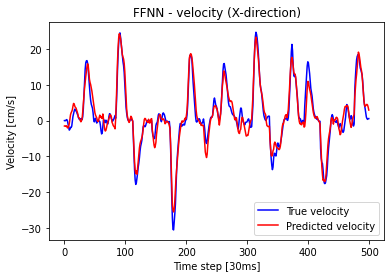

In [20]:
# Feedforward NN decoder plots
fig_x_DNN=plt.figure()
plt.plot(y_valid[1000:1500,0]+y_train_mean[0],'b', label="True velocity")
plt.plot(y_valid_predicted_dnn[1000:1500,0]+y_train_mean[0],'r', label="Predicted velocity")
plt.title("FFNN - velocity (X-direction)")
plt.legend(loc="best")
plt.xlabel("Time step [30ms]")
plt.ylabel("Velocity [cm/s]")
#plt.savefig('Figures/Actual/FFNN_vel_X.eps', format='eps')
#plt.savefig('Figures/Actual/FFNN_vel_X.png')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


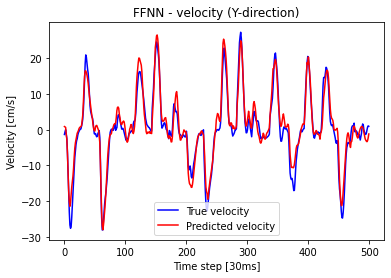

In [21]:
# Feedforward NN decoder plots
fig_x_DNN=plt.figure()
plt.plot(y_valid[1000:1500,1]+y_train_mean[1],'b', label="True velocity")
plt.plot(y_valid_predicted_dnn[1000:1500,1]+y_train_mean[1],'r', label="Predicted velocity")
plt.title("FFNN - velocity (Y-direction)")
plt.legend(loc="best")
plt.xlabel("Time step [30ms]")
plt.ylabel("Velocity [cm/s]")
#plt.savefig('Figures/Actual/FFNN_vel_Y.eps', format='eps')
#plt.savefig('Figures/Actual/FFNN_vel_Y.png')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


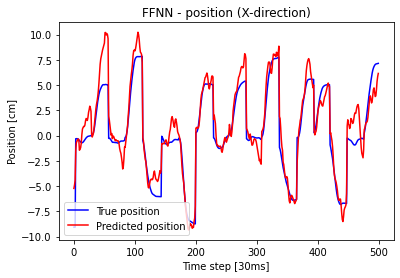

In [37]:
# Feedforward NN decoder plots
fig_x_DNN=plt.figure()
plt.plot(y_valid[1000:1500,0]+y_train_mean[0],'b', label="True position")
plt.plot(y_valid_predicted_dnn[1000:1500,0]+y_train_mean[0],'r', label="Predicted position")
plt.title("FFNN - position (X-direction)")
plt.legend(loc="best")
plt.xlabel("Time step [30ms]")
plt.ylabel("Position [cm]")
plt.savefig('Figures/Actual/FFNN_pos_X.eps', format='eps')
plt.savefig('Figures/Actual/FFNN_pos_X.png')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


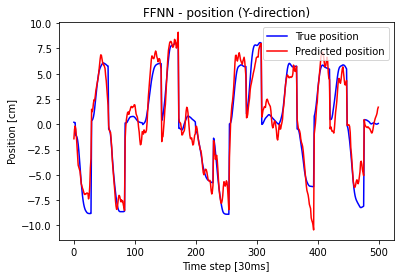

In [38]:
# Feedforward NN decoder plots
fig_x_DNN=plt.figure()

# Transform back to original coordinates - not used because original are centered aorund - 30
#plt.plot(y_valid[1000:1500,1]+y_train_mean[1],'b', label="True position")
#plt.plot(y_valid_predicted_dnn[1000:1500,1]+y_train_mean[1],'r', label="Predicted position")

plt.plot(y_valid[1000:1500,1],'b', label="True position")
plt.plot(y_valid_predicted_dnn[1000:1500,1],'r', label="Predicted position")

plt.title("FFNN - position (Y-direction)")
plt.legend(loc="best")
plt.xlabel("Time step [30ms]")
plt.ylabel("Position [cm]")
plt.savefig('Figures/Actual/FFNN_pos_Y.eps', format='eps')
plt.savefig('Figures/Actual/FFNN_pos_Y.png')
plt.show()

### 4F. Simple RNN

In [10]:
#Declare model
model_rnn=SimpleRNNDecoder(units=400,dropout=0,num_epochs=5)

#Fit model
model_rnn.fit(X_train,y_train)

#Get predictions
y_valid_predicted_rnn=model_rnn.predict(X_valid)

#Get metric of fit
R2s_rnn=get_R2(y_valid,y_valid_predicted_rnn)
print('R2s:', R2s_rnn)

KeyboardInterrupt: 

### 4G. GRU (Gated Recurrent Unit)

In [15]:
#Declare model
model_gru=GRUDecoder(units=400,dropout=0,num_epochs=5)

#Fit model
model_gru.fit(X_train,y_train)

#Get predictions
y_valid_predicted_gru=model_gru.predict(X_valid)

#Get metric of fit
R2s_gru=get_R2(y_valid,y_valid_predicted_gru)
print('R2s:', R2s_gru)

R2s: [0.83770423 0.83575681]


### 4H. LSTM (Long Short Term Memory)

In [95]:
#Declare model
model_lstm=LSTMDecoder(units=560,dropout=0.42818225,num_epochs=12)

#Fit model
model_lstm.fit(X_train,y_train)

#Get predictions
y_valid_predicted_lstm=model_lstm.predict(X_valid)

#Get metric of fit
R2s_lstm=get_R2(y_valid,y_valid_predicted_lstm)
print('R2s:', R2s_lstm)

R2s: [0.93432516 0.93279978]


In [96]:
# Trying out sklearn R2 metrix
R2_ua = r2_score(y_valid,y_valid_predicted_lstm, multioutput='uniform_average')
R2_vw = r2_score(y_valid,y_valid_predicted_lstm, multioutput='variance_weighted')


print('Uniform average R2s: ', R2_ua)
print('Variance weighted R2s: ', R2_vw)

Uniform average R2s:  0.9335624662287916
Variance weighted R2s:  0.9335450963429044


### 4 - Side note on memory usage in TensorFlow
When using the tensorflow backend for Keras (which is standard in newer versions), there can be issues with memory leakage, particularly when fitting many models. To avoid this problem, models can be deleted with the following code:

```
import gc
from keras import backend as K

del model_lstm
K.clear_session()
gc.collect()
```

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


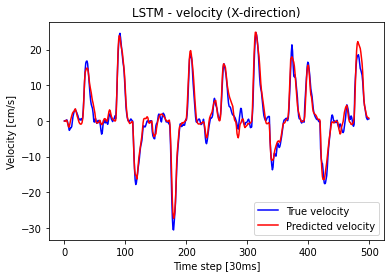

In [17]:
# LSTM decoder plots
fig_x_LSTM=plt.figure()
plt.plot(y_valid[1000:1500,0]+y_train_mean[0],'b', label="True velocity")
plt.plot(y_valid_predicted_lstm[1000:1500,0]+y_train_mean[0],'r', label="Predicted velocity")
plt.title("LSTM - velocity (X-direction)")
plt.legend(loc="best")
plt.xlabel("Time step [30ms]")
plt.ylabel("Velocity [cm/s]")
#plt.savefig('Figures/Actual/LSTM_vel_X.eps', format='eps')
#plt.savefig('Figures/Actual/LSTM_vel_X.png')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


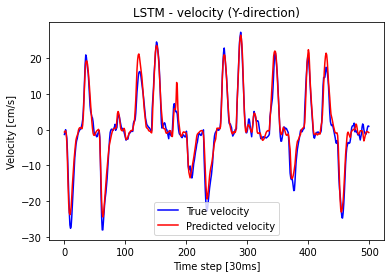

In [19]:
# LSTM NN decoder plots
fig_x_lstm=plt.figure()
plt.plot(y_valid[1000:1500,1]+y_train_mean[1],'b', label="True velocity")
plt.plot(y_valid_predicted_lstm[1000:1500,1]+y_train_mean[1],'r', label="Predicted velocity")
plt.title("LSTM - velocity (Y-direction)")
plt.legend(loc="best")
plt.xlabel("Time step [30ms]")
plt.ylabel("Velocity [cm/s]")
#plt.savefig('Figures/Actual/LSTM_vel_Y.eps', format='eps')
#plt.savefig('Figures/Actual/LSTM_vel_Y.png')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


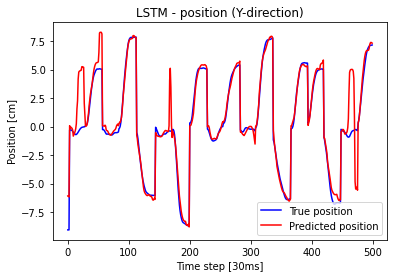

In [43]:
# LSTM NN decoder plots
fig_x_lstm=plt.figure()
plt.plot(y_valid[1000:1500,0]+y_train_mean[0],'b', label="True position")
plt.plot(y_valid_predicted_lstm[1000:1500,0]+y_train_mean[0],'r', label="Predicted position")
plt.title("LSTM - position (Y-direction)")
plt.legend(loc="best")
plt.xlabel("Time step [30ms]")
plt.ylabel("Position [cm]")
#plt.savefig('Figures/Actual/LSTM_pos_X.eps', format='eps')
#plt.savefig('Figures/Actual/LSTM_pos_X.png')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


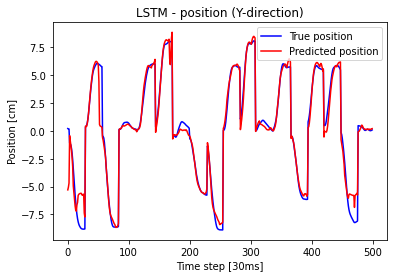

In [44]:
# LSTM NN decoder plots
fig_x_lstm=plt.figure()
plt.plot(y_valid[1000:1500,1],'b', label="True position")
plt.plot(y_valid_predicted_lstm[1000:1500,1],'r', label="Predicted position")
plt.title("LSTM - position (Y-direction)")
plt.legend(loc="best")
plt.xlabel("Time step [30ms]")
plt.ylabel("Position [cm]")
plt.savefig('Figures/Actual/LSTM_pos_Y.eps', format='eps')
plt.savefig('Figures/Actual/LSTM_pos_Y.png')
plt.show()

## 5. Make Plots

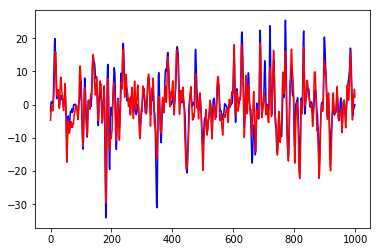

In [18]:
#As an example, I plot an example 1000 values of the x velocity (column index 0), both true and predicted with the Wiener filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_wf=plt.figure()
plt.plot(y_valid[1000:2000,0]+y_train_mean[0],'b')
plt.plot(y_valid_predicted_wf[1000:2000,0]+y_train_mean[0],'r')

#Save figure
# fig_x_wf.savefig('x_velocity_decoding.eps')